In [15]:
# resources 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import warnings

# collect data
from bcb import sgs

# modeling series 
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsmodels.tsa.seasonal import seasonal_decompose 

# ploting
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler, Normalizer

warnings.filterwarnings('ignore')

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

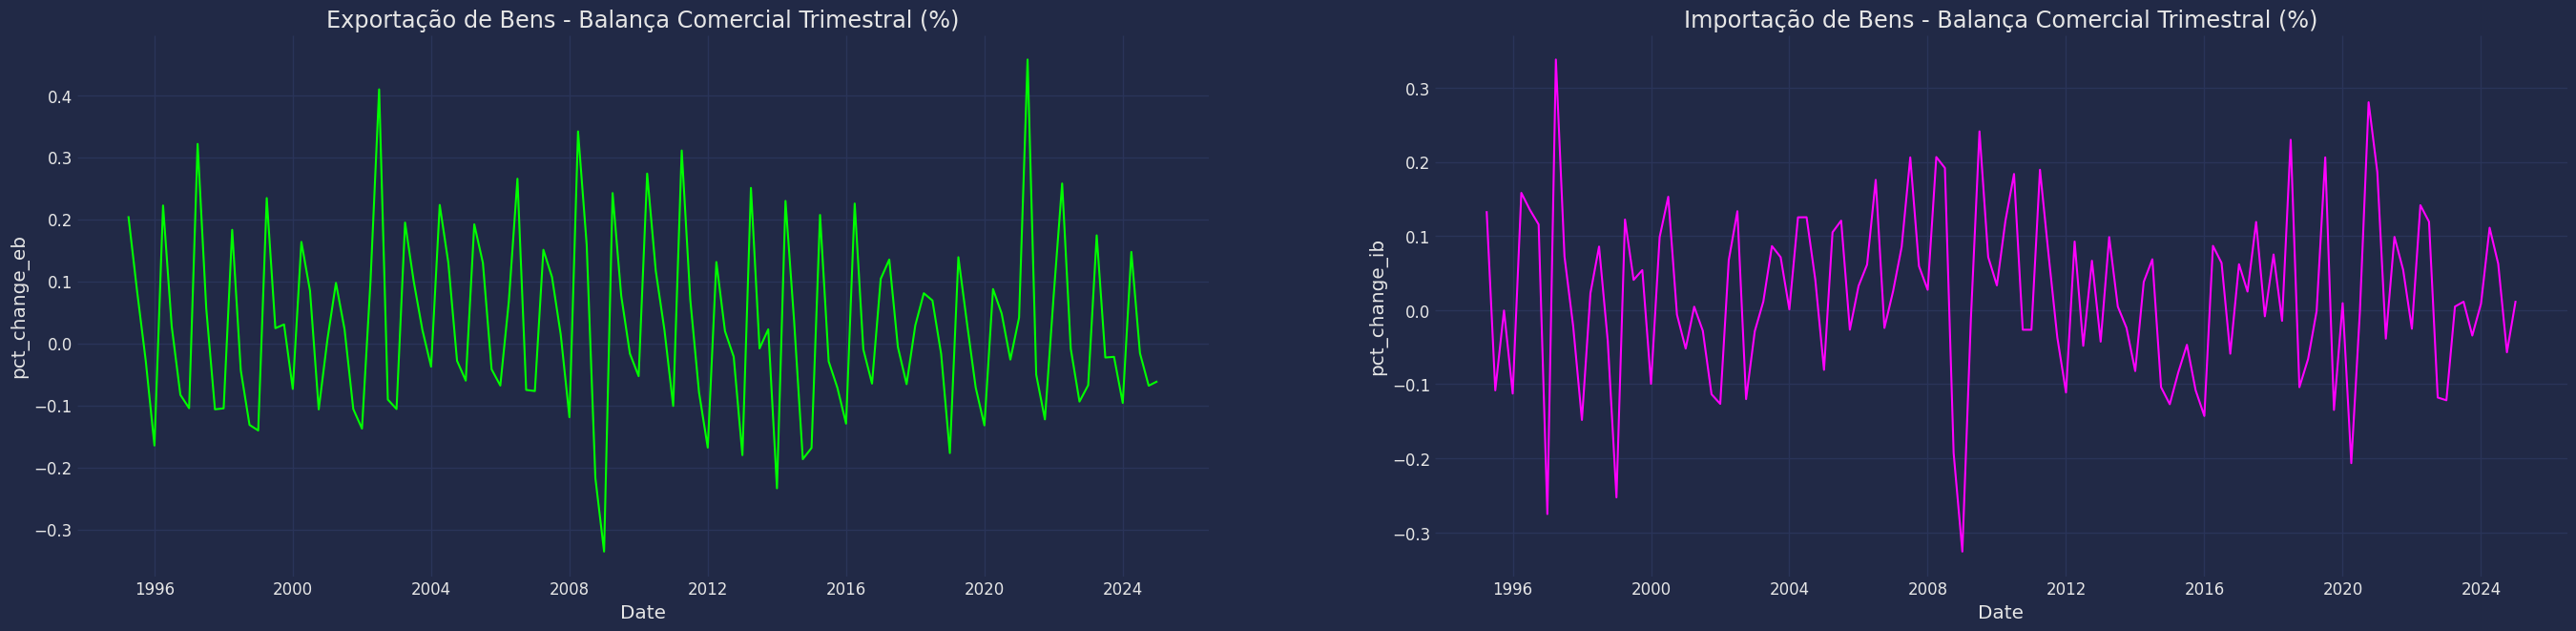

In [ ]:
BALANCA_COMERCIAL_TRIMESTRAL = {
    'BALANCA_COMERCIAL': 23087,
    'EXPORTACAO_BENS': 23088,
    'IMPORTACAO_BENS': 23089
}

bc_tri = pd.DataFrame(sgs.get(BALANCA_COMERCIAL_TRIMESTRAL))
bc_tri['pct_change_bc'] = bc_tri['BALANCA_COMERCIAL'].pct_change()
bc_tri['pct_change_eb'] = bc_tri['EXPORTACAO_BENS'].pct_change()
bc_tri['pct_change_ib'] = bc_tri['IMPORTACAO_BENS'].pct_change()
bc_tri_not_float = bc_tri[['pct_change_eb', 'pct_change_ib']].round(2)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 7), sharex=True)

sns.lineplot(data=bc_tri, x=bc_tri.index, y='pct_change_eb', ax=axs[0], color='lime')
axs[0].set_title('Exportação de Bens - Balança Comercial Trimestral (%)')
sns.lineplot(data=bc_tri, x=bc_tri.index, y='pct_change_ib', ax=axs[1], color='fuchsia')
axs[1].set_title('Importação de Bens - Balança Comercial Trimestral (%)')

plt.show()

Autocorrelação entre os trimestres: 70.1518%


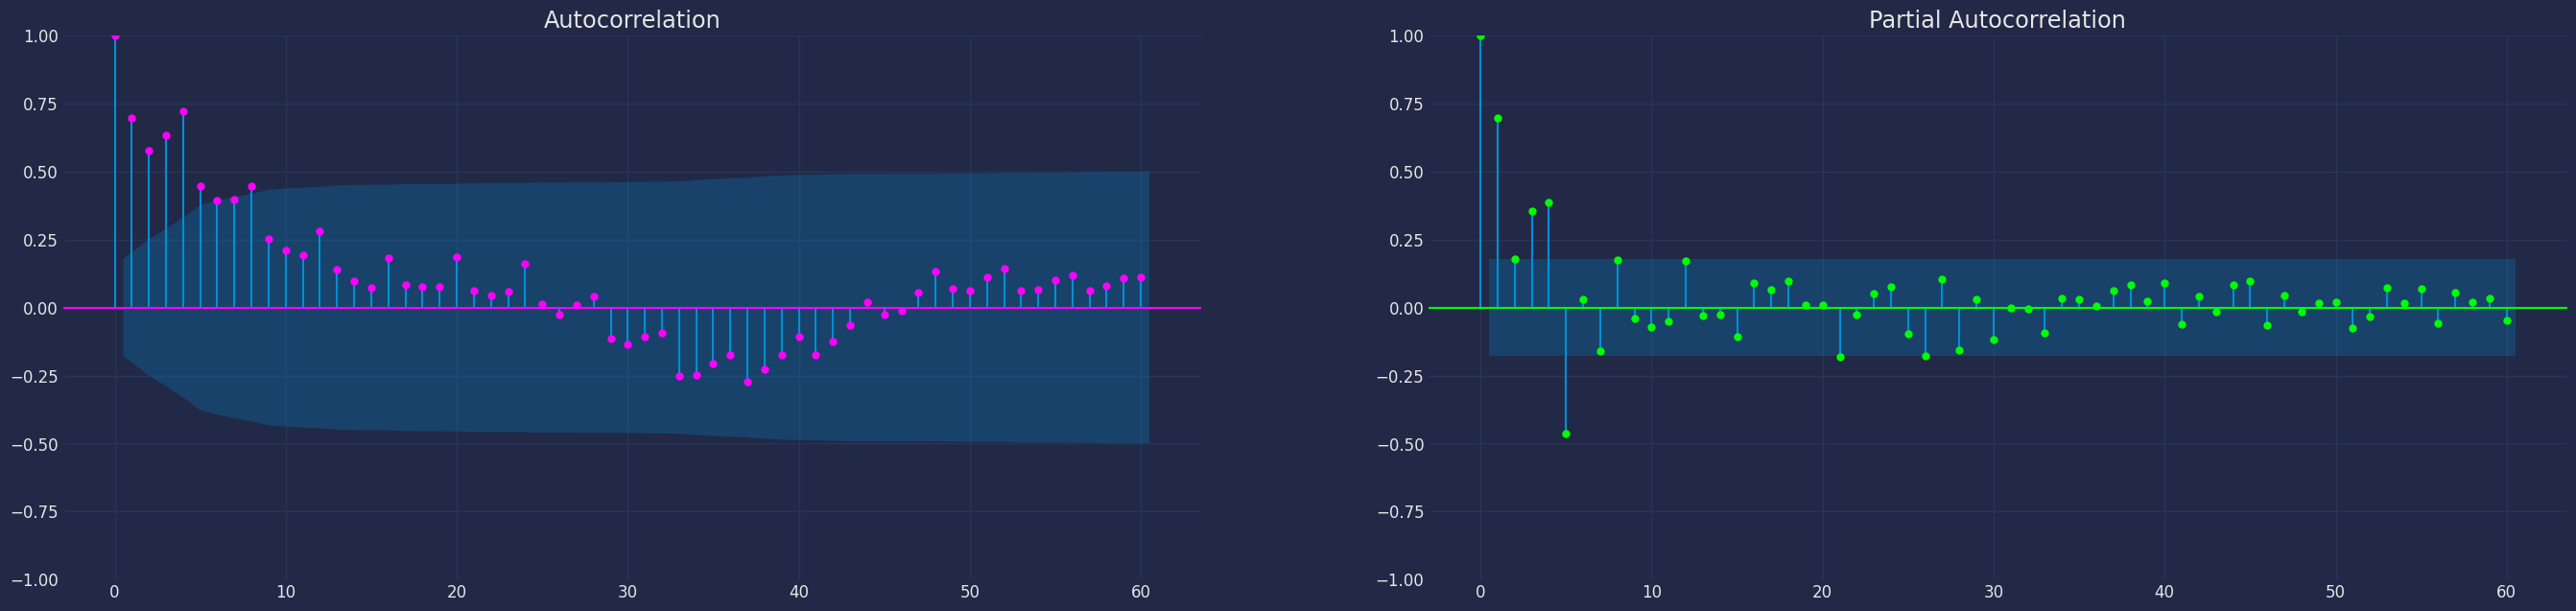

In [13]:
matplotlib.rcParams['figure.figsize'] = (30, 7)
bc = bc_tri['BALANCA_COMERCIAL'].reset_index()
bc.loc[:, 'lag1_bc'] = bc['BALANCA_COMERCIAL'].shift(1)
bc['Date'] = pd.to_datetime(bc['Date'])
bc.set_index('Date', inplace=True)

autocorr = bc['BALANCA_COMERCIAL'].autocorr(lag=1)
print(f"Autocorrelação entre os trimestres: {(np.round(autocorr, 6) * 100)}%")


fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(bc["BALANCA_COMERCIAL"],  lags=60, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation")

plot_pacf(bc["BALANCA_COMERCIAL"],  lags=60, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show()

**y(t)=Level∗Trend∗seasonality∗Noise**

* This formula represents a time series decomposition model where:
* y(t) - The observed value at time t.
* Level - The baseline level of the time series.
* Trend - The long-term progression or direction of the time series.
* Seasonality - The repeating patterns or cycles in the time series.
* Noise - The random variation or error component in the time series.
* The components are multiplicative, meaning the observed value is the product of these factors.

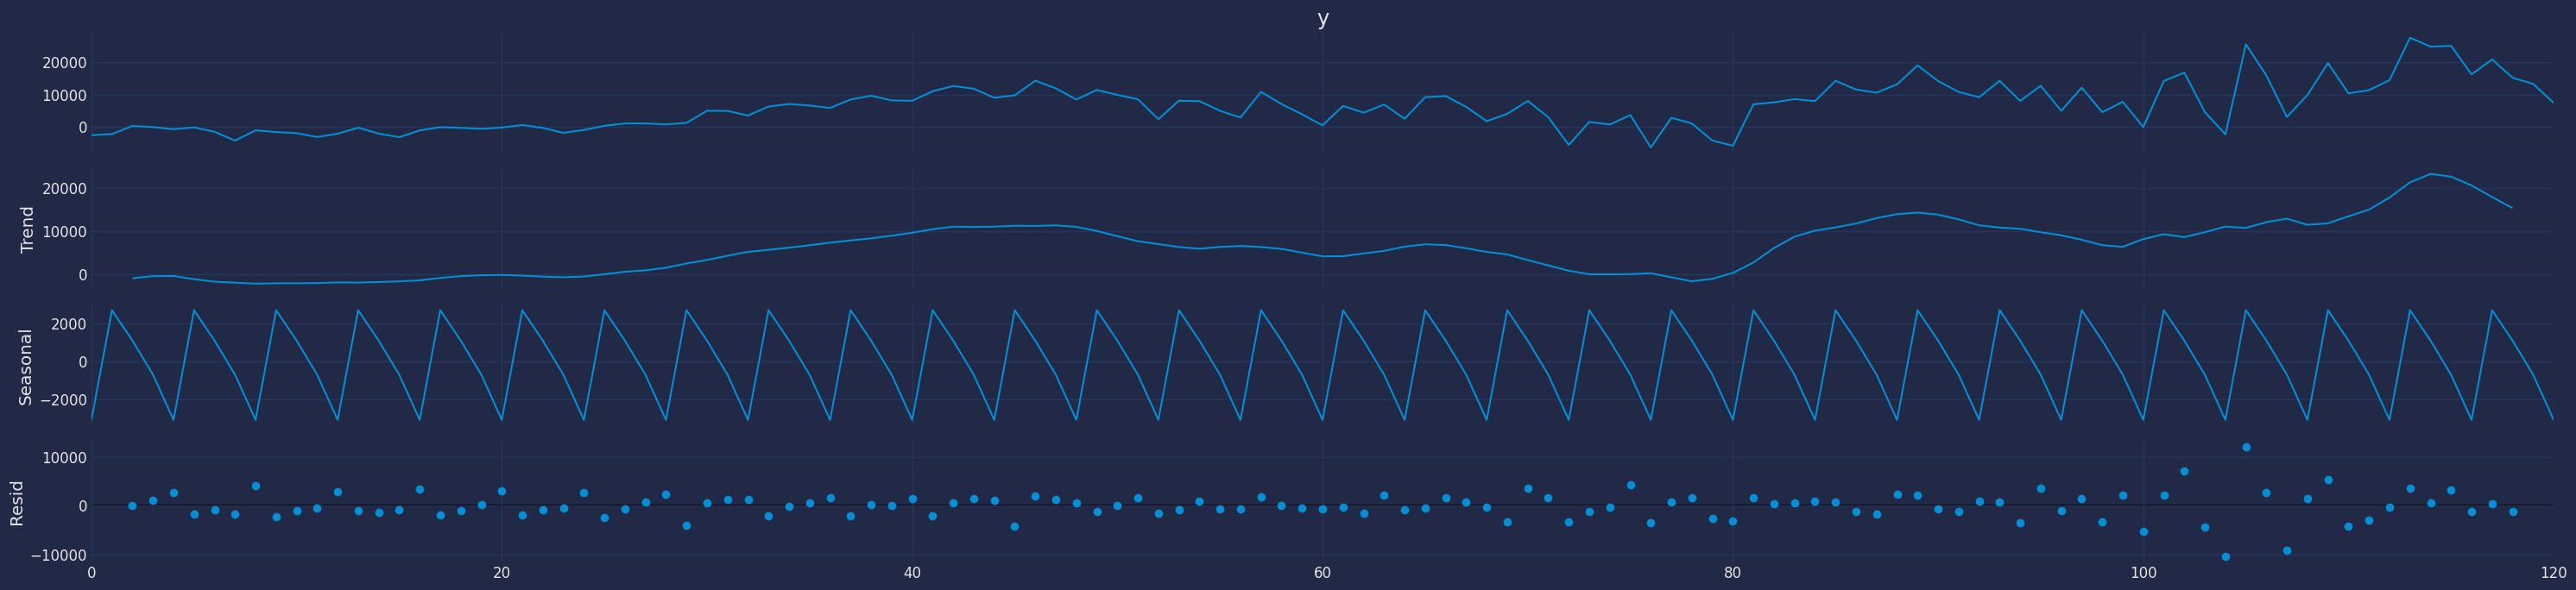

In [20]:
bc_df = (
    bc.reset_index()
    .assign(unique_id='bc')
    .rename(columns={'Date': 'ds', 'BALANCA_COMERCIAL': 'y'})
    .drop(columns=['lag1_bc'])
)

result = seasonal_decompose(bc_df['y'], model='add', period=4).plot()

models = [AutoARIMA(season_length=4, approximation=True)]
bc_df = bc_df[['unique_id', 'ds', 'y']].sort_values(by='ds')
sf = StatsForecast(
    models=models,
    freq='QE',
    n_jobs=-1
)

forecast_df = sf.forecast(df=bc_df, h=121, level=[95], fitted=True)

#adjust
insample_forecasts = sf.forecast_fitted_values().reset_index()

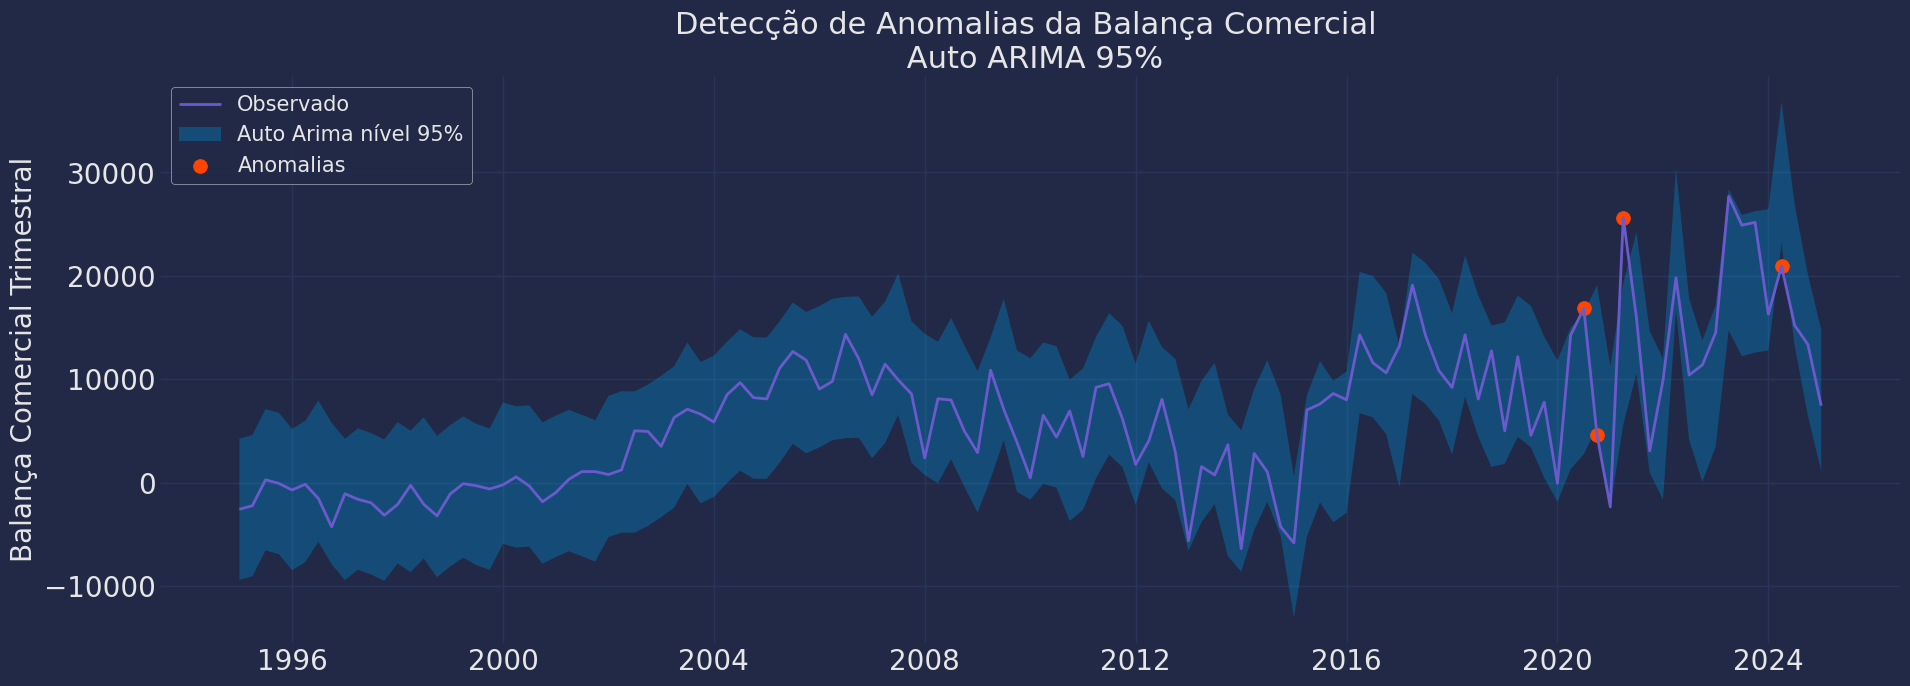

In [24]:
#plot graph
COLOR_GRAPHS_SLATEBLUE = 'slateblue'
COLOR_GRAPHS_ORANGERED = 'orangered'

fig, ax = plt.subplots(1,1, figsize=(20, 7))
ax.plot(insample_forecasts['ds'], 
        insample_forecasts['y'],
        linewidth=2, 
        label='Observado', 
        color=COLOR_GRAPHS_SLATEBLUE)

ax.fill_between(
    insample_forecasts['ds'],
    insample_forecasts['AutoARIMA-lo-95'],
    insample_forecasts['AutoARIMA-hi-95'],
    alpha = .35,
    label='Auto Arima nível 95%'
)

anomalies_df = insample_forecasts.query('y > `AutoARIMA-hi-95` or y < `AutoARIMA-lo-95`')[['ds', 'y']]
ax.scatter(
    anomalies_df['ds'], 
    anomalies_df['y'], 
    color=COLOR_GRAPHS_ORANGERED, 
    label='Anomalias',
    s=100
)

ax.set_title(f'Detecção de Anomalias da Balança Comercial \n Auto ARIMA 95%', fontsize=22)
ax.set_ylabel('Balança Comercial Trimestral', fontsize=20)
ax.legend(prop={'size': 15})
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
plt.show()

anomalies_insights = anomalies_df.copy()